In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})


In [5]:
df = pd.read_csv("F:/360/Dataset_Cement.csv",
                       index_col ='Month',
                       parse_dates = True)

In [6]:
df

,City,Region,Product Type,Order_quantity(MT),Sale_quantity(MT),Unit_price,Total_price,Limestone(MT),Transportation Cost,Housing Interest Rate,GDP Construction
Month,,,,,,,,,,,
2015-01-01,Vijayawada,Southern,PSC,5.91,5.71,390,2226.90,8.9,467.65,7.5,214180
2015-02-01,Tirupati,Southern,PPC,5.42,5.41,385,2082.85,8.1,416.57,8.1,214179
2015-03-01,Mumbai,Western,OPC 43,4.82,4.75,380,1805.00,7.2,397.10,7.9,214181
2015-04-01,Bangalore,Southern,PSC,4.68,4.55,395,1797.25,7.0,377.42,8.5,218253
2015-05-01,Pune,Western,OPC 43,4.69,4.56,400,1824.00,7.0,401.28,7.6,218252
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,Chennai,Southern,OPC 43,7.42,7.35,371,2726.34,11.1,490.74,9.2,259017
2022-09-01,Vijayawada,Southern,OPC 43,8.23,8.14,387,3149.20,12.3,566.86,8.1,259019
2022-10-01,Tirupati,Southern,PSC,8.33,8.26,372,3073.71,12.5,645.48,7.4,258010


In [7]:
df.columns

Index(['City', 'Region', 'Product  Type', 'Order_quantity(MT)',
       'Sale_quantity(MT)', 'Unit_price', 'Total_price', 'Limestone(MT)',
       'Transportation Cost', 'Housing Interest Rate', 'GDP Construction'],
      dtype='object')

In [8]:
df.drop(columns={'City', 'Region', 'Product  Type', 'Order_quantity(MT)',
        'Unit_price', 'Total_price', 'Limestone(MT)',
       'Transportation Cost', 'Housing Interest Rate', 'GDP Construction'},inplace=True)

In [9]:
df.head()

,Sale_quantity(MT)
Month,
2015-01-01,5.71
2015-02-01,5.41
2015-03-01,4.75
2015-04-01,4.55
2015-05-01,4.56


In [10]:
df.rename(columns={"Sale_quantity(MT)":"Sales"},inplace=True)

In [11]:
df.head()

,Sales
Month,
2015-01-01,5.71
2015-02-01,5.41
2015-03-01,4.75
2015-04-01,4.55
2015-05-01,4.56


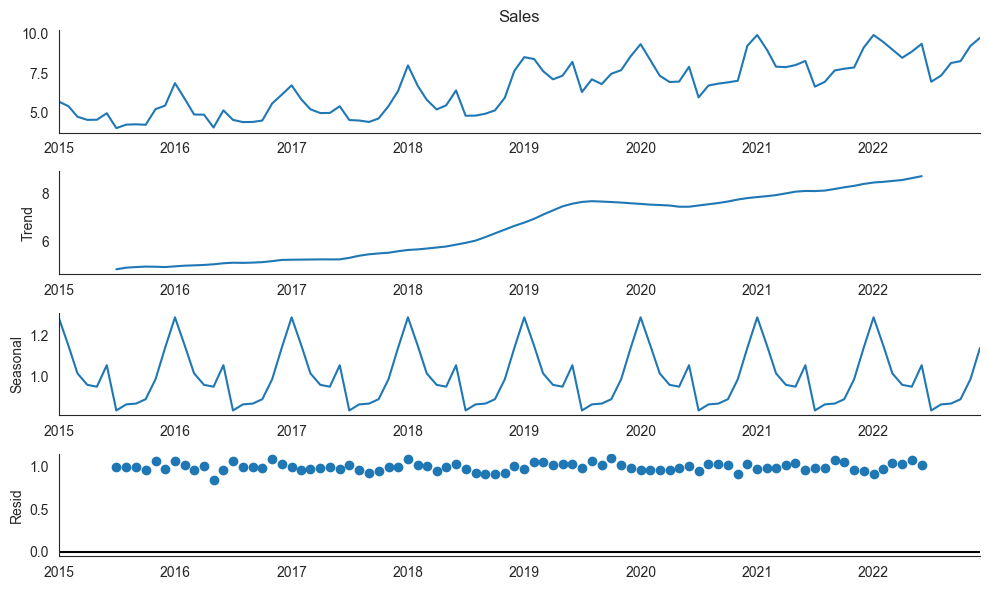

In [12]:
# Decompose the time series
plt.rcParams["figure.figsize"] = (10,6)
result = seasonal_decompose(df['Sales'], model='multiplicative', period = 12)
result.plot()
plt.show()



<AxesSubplot: xlabel='Month'>

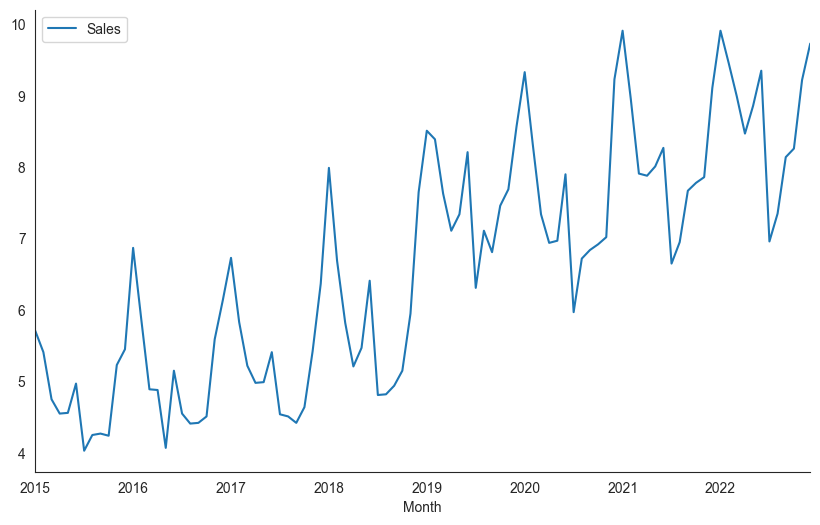

In [13]:
df.plot()

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:

test_result=adfuller(df['Sales'])

In [16]:
def adfuller_test(Sales):
    result = adfuller(Sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    

In [17]:
adfuller_test(df["Sales"])

ADF Test Statistic : 0.19741375433185904
p-value : 0.972116165685089
#Lags Used : 12
Number of Observations : 83


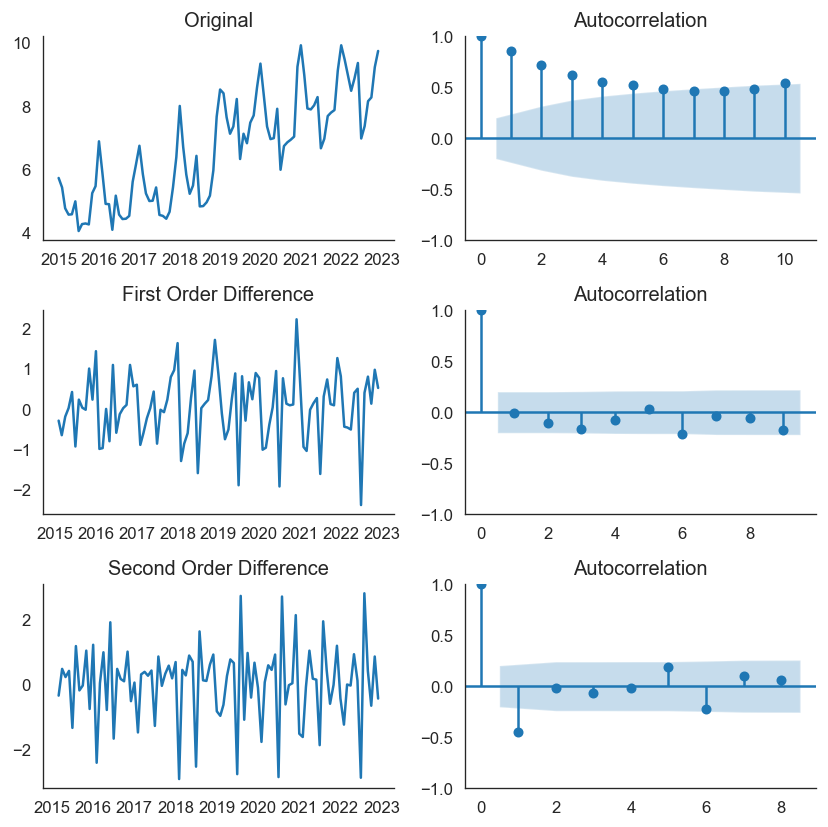

In [18]:
def auto_correlation(df, prefix, lags):
    plt.rcParams.update({'figure.figsize':(7,7), 'figure.dpi':120})
    
    # Define the plot grid
    fig, axes = plt.subplots(3,2, sharex=False)

    # First Difference
    axes[0, 0].plot(df)
    axes[0, 0].set_title('Original' + prefix)
    plot_acf(df, lags=lags, ax=axes[0, 1])

    # First Difference
    df_first_diff = df.diff().dropna()
    axes[1, 0].plot(df_first_diff)
    axes[1, 0].set_title('First Order Difference' + prefix)
    plot_acf(df_first_diff, lags=lags - 1, ax=axes[1, 1])

    # Second Difference
    df_second_diff = df.diff().diff().dropna()
    axes[2, 0].plot(df_second_diff)
    axes[2, 0].set_title('Second Order Difference' + prefix)
    plot_acf(df_second_diff, lags=lags - 2, ax=axes[2, 1])
    plt.tight_layout()
    plt.show()
    
auto_correlation(df['Sales'], '', 10)


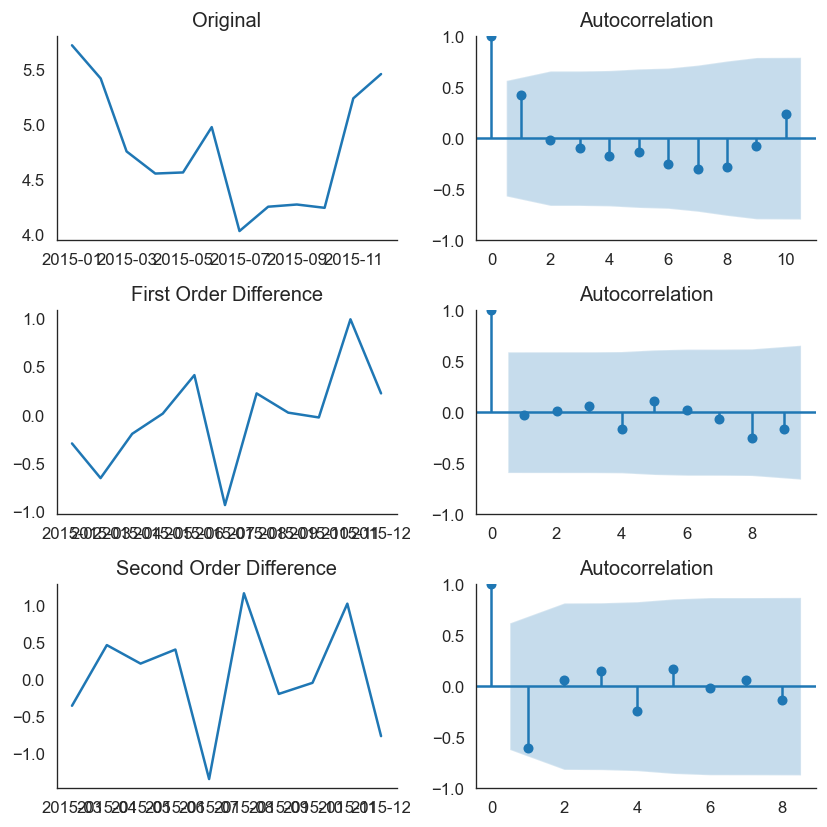

In [19]:
# Reduce the timeframe to a single seasonal period
df_sales = df['Sales'][0:12]

# Autocorrelation for the seasonal part
auto_correlation(df_sales, '', 10)


In [20]:
# split into train and test
pred_periods = 30
split_number = df['Sales'].count() - pred_periods # corresponds to a prediction horizion  of 2,5 years
df_train = pd.DataFrame(df['Sales'][:split_number]).rename(columns={'Sales':'y_train'})
df_test = pd.DataFrame(df['Sales'][split_number:]).rename(columns={'Sales':'y_test'})

# auto_arima
model_fit = pm.auto_arima(df_train, test='adf', 
                         max_p=3, max_d=3, max_q=3, 
                         seasonal=True, m=12,
                         max_P=3, max_D=2, max_Q=3,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

# summarize the model characteristics
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=69.989, Time=2.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=75.354, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=63.186, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=62.877, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=73.594, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=64.870, Time=0.85 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=64.875, Time=0.63 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=63.551, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=66.559, Time=0.14 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=64.312, Time=0.42 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=64.275, Time=0.29 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=62.350, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=73.468, Time=0.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=64.328,

In [21]:
result.plot_diagnostics(figsize=(20, 14))
plt.show()


AttributeError: 'DecomposeResult' object has no attribute 'plot_diagnostics'

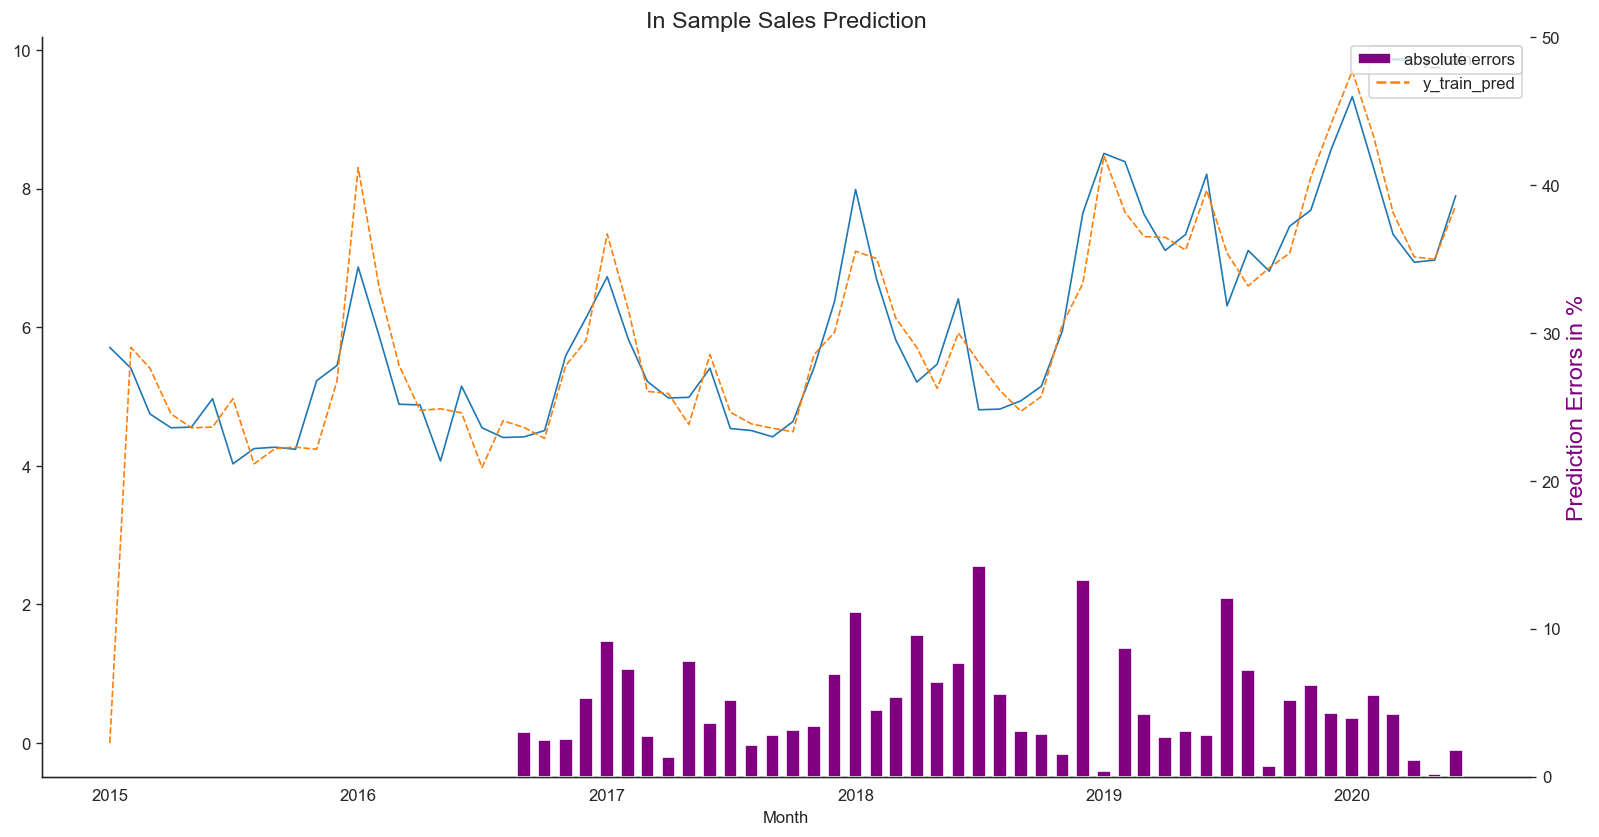

In [22]:
# Generate in-sample Predictions
# The parameter dynamic=False means that the model makes predictions upon the lagged values.
# This means that the model is trained until a point in the time-series and then tries to predict the next value.
pred = model_fit.predict_in_sample(dynamic=False) # works only with auto-arima
df_train['y_train_pred'] = pred

# Calculate the percentage difference
df_train['diff_percent'] = abs((df_train['y_train'] - pred) / df_train['y_train'])* 100

# Print the predicted time-series
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("In Sample Sales Prediction", fontsize=14)
sns.lineplot(data=df_train[['y_train', 'y_train_pred']], linewidth=1.0)

# Print percentage prediction errors on a separate axis (ax2)
ax2 = ax1.twinx() 
ax2.set_ylabel('Prediction Errors in %', color='purple', fontsize=14)  
ax2.set_ylim([0, 50])
ax2.bar(height=df_train['diff_percent'][20:], x=df_train.index[20:], width=20, color='purple', label='absolute errors')
plt.legend()
plt.show()


IndexError: index 105 is out of bounds for axis 0 with size 96

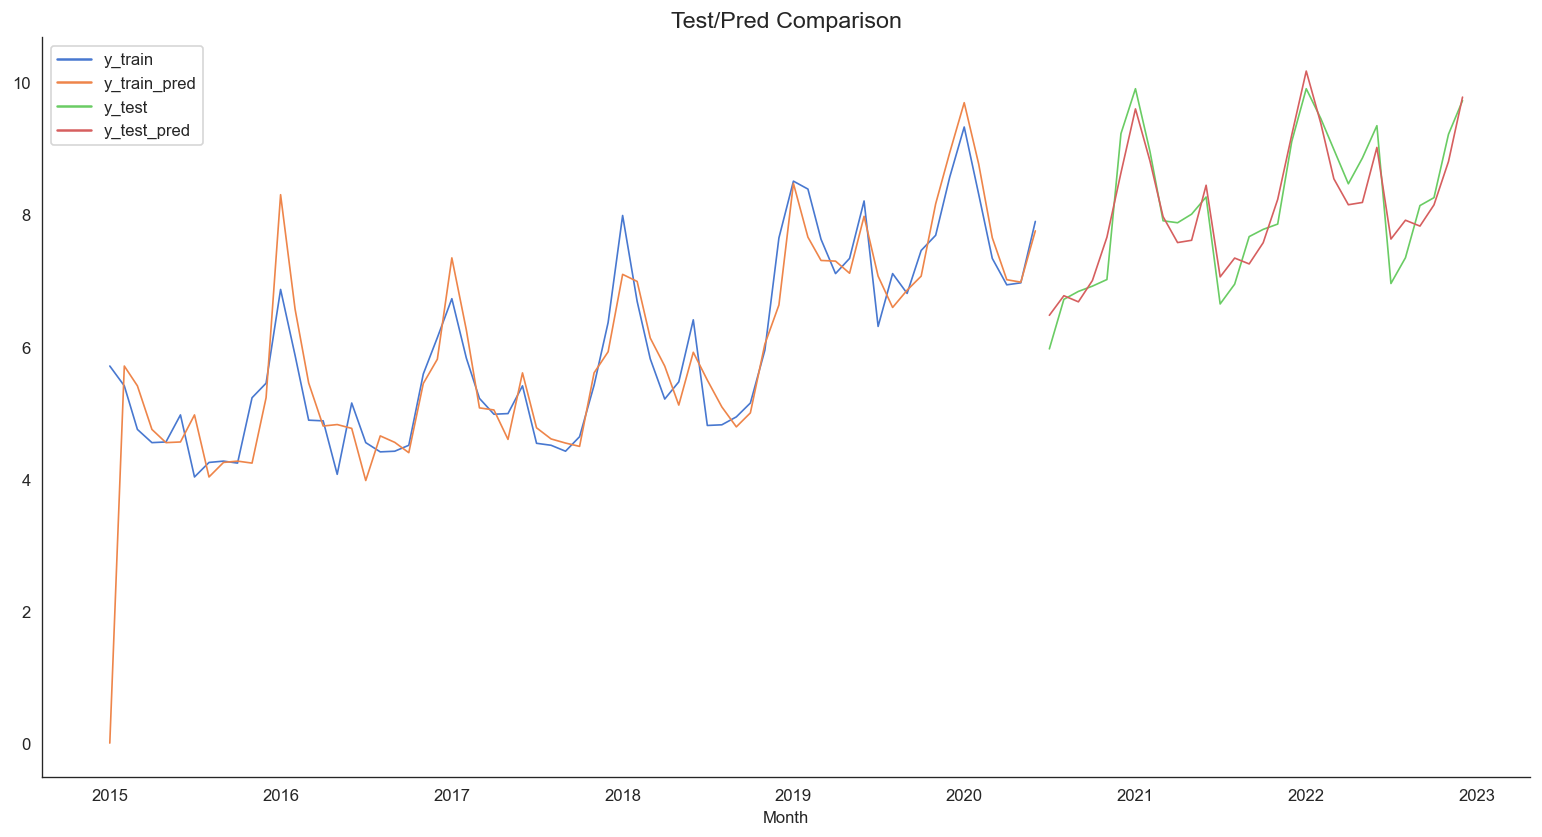

In [23]:
# Generate prediction for n periods, 
# Predictions start from the last date of the training data
test_pred = model_fit.predict(n_periods=pred_periods, dynamic=False)
df_test['y_test_pred'] = test_pred
df_union = pd.concat([df_train, df_test])
df_union.rename(columns={'Sales':'y_test'}, inplace=True)

# Print the predicted time-series
fig, ax = plt.subplots(figsize=(16, 8))
plt.title("Test/Pred Comparison", fontsize=14)
sns.despine();
sns.lineplot(data=df_union[['y_train', 'y_train_pred', 'y_test', 'y_test_pred']], linewidth=1.0, dashes=False, palette='muted')
ax.set_xlim([df_union.index[105],df_union.index.max()])
plt.legend()
plt.show()

In [24]:
# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(df_test['y_test'], df_test['y_test_pred'])/ df_test['y_test']))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(df_test['y_test'], df_test['y_test_pred'])/ df_test['y_test'])) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')


Mean Absolute Percentage Error (MAPE): 4.04 %
Median Absolute Percentage Error (MDAPE): 3.78 %


In [25]:
from pmdarima.arima import auto_arima
from pmdarima.datasets import load_lynx
import numpy as np



In [26]:
# For serialization:
import joblib
import pickle



In [27]:
# Load data and fit a model
y = load_lynx("F:/360/Dataset_Cement.csv")
arima = auto_arima(y, seasonal=True)



In [30]:
# Serialize with Pickle
with open('arima.pkl', 'wb') as pkl:
    pickle.dump(arima, pkl)



In [31]:
# You can still make predictions from the model at this point
arima.predict(n_periods=5)



1935    2850.911343
1936    1929.902297
1937    1085.509909
1938     346.578833
1939       1.171471
dtype: float64

In [32]:
# Now read it back and make a prediction
with open('arima.pkl', 'rb') as pkl:
    pickle_preds = pickle.load(pkl).predict(n_periods=5)



In [33]:
# Or maybe joblib tickles your fancy
joblib.dump(arima, 'arima.pkl')
joblib_preds = joblib.load('arima.pkl').predict(n_periods=5)



In [34]:
# show they're the same
np.allclose(pickle_preds, joblib_preds)

True